In [ ]:
from sklearn import metrics
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from matplotlib import pyplot as plt
import duckdb
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

con = duckdb.connect("database.db", read_only=True)
jaccard = metrics.DistanceMetric.get_metric('jaccard')
cosine_distances = metrics.pairwise.cosine_distances

In [143]:
# building the distance matrix from jaccard metric on albums
artists_df = con.sql("SELECT DISTINCT spotify_id, name FROM artists ORDER BY spotify_id ASC").df()
albums_df = con.sql("SELECT DISTINCT album_id, artist_id as spotify_id from album_artist").df()
# pivot to create binary features for each album
albums_features = albums_df.assign(has_album=1).pivot(index="spotify_id", columns="album_id", values="has_album").fillna(0)
# join back to artists to ensure all artists are included (in case some artists have no albums?)
albums_features = artists_df.drop(columns=["name"]).set_index("spotify_id").join(albums_features, how="left").fillna(0)
# reorder to match artists_df alphabetical order and convert to numpy
albums_features.reindex(artists_df["spotify_id"]).to_numpy()
albums_matrix = jaccard.pairwise(albums_features, albums_features)
print(albums_matrix)

[[0. 1. 1. ... 1. 1. 1.]
 [1. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


In [256]:
# building the distance matrix from jaccard metric on genres
genres_df = con.sql("SELECT artist_id as spotify_id, genre from artist_genre").df()
# pivot to create binary features for each genre
genre_features = genres_df.assign(has_genre=1).pivot(index="spotify_id", columns="genre", values="has_genre").fillna(0)
# join back to artists to ensure all artists are included (even those without genres)
genre_features = artists_df.drop(columns=["name"]).set_index("spotify_id").join(genre_features, how="left").fillna(0)
# reorder to match artists_df alphabetical order and convert to numpy
genre_features.reindex(artists_df["spotify_id"]).to_numpy()
genre_matrix = jaccard.pairwise(genre_features, genre_features)
print(genre_matrix)

[[0. 0. 1. ... 1. 1. 1.]
 [0. 0. 1. ... 1. 1. 1.]
 [1. 1. 0. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 0. 1. 1.]
 [1. 1. 1. ... 1. 0. 1.]
 [1. 1. 1. ... 1. 1. 0.]]


In [181]:
# building the distance matrix from cosine distances on tags
tags_df = con.sql("SELECT spotify_id, name, tag, weight from artists LEFT JOIN artist_tag ON artists.mbid=artist_tag.mbid ORDER BY spotify_id ASC").df()
# pivot to create weighted features for each tag
tag_features = tags_df.pivot(index="spotify_id", columns="tag", values="weight").fillna(0)
# reorder to match artists_df alphabetical order and convert to numpy
tag_features = tag_features.reindex(artists_df["spotify_id"]).to_numpy()
# normalize the tag features
tag_features = normalize(tag_features, norm='l2')
tag_matrix = metrics.pairwise.cosine_distances(tag_features, tag_features)
print(tag_matrix)

[[0.         1.         0.96481912 ... 0.64558886 1.         0.99184572]
 [1.         0.         1.         ... 1.         1.         1.        ]
 [0.96481912 1.         0.         ... 0.99767989 1.         1.        ]
 ...
 [0.64558886 1.         0.99767989 ... 0.         0.98241398 0.98679736]
 [1.         1.         1.         ... 0.98241398 0.         1.        ]
 [0.99184572 1.         1.         ... 0.98679736 1.         0.        ]]


In [189]:
dates_df = con.sql("SELECT artist_id as spotify_id, release_date, added_at FROM albums INNER JOIN album_artist on albums.spotify_id=album_artist.album_id ORDER BY spotify_id ASC").df()
dates_df = dates_df.groupby("spotify_id").agg({"release_date": "mean", "added_at": "mean"})
dates_features = dates_df.assign(
    release_date=dates_df["release_date"].astype("int64"), 
    added_at=dates_df["added_at"].astype("int64"), 
    )
dates_features = dates_features.reindex(artists_df["spotify_id"])
dates_features_scaled = StandardScaler().fit_transform(dates_features)
release_features = 0.5 * dates_features_scaled[:, 0].reshape(-1, 1)
added_features = 0.5 * dates_features_scaled[:, 1].reshape(-1, 1)
release_matrix = metrics.pairwise.euclidean_distances(release_features, release_features)
added_matrix = metrics.pairwise.euclidean_distances(added_features, added_features)
print(release_matrix)

[[0.         1.11481446 1.46673653 ... 0.67028132 0.03022045 0.19413509]
 [1.11481446 0.         0.35192207 ... 0.44453314 1.14503491 0.92067937]
 [1.46673653 0.35192207 0.         ... 0.7964552  1.49695698 1.27260144]
 ...
 [0.67028132 0.44453314 0.7964552  ... 0.         0.70050178 0.47614624]
 [0.03022045 1.14503491 1.49695698 ... 0.70050178 0.         0.22435554]
 [0.19413509 0.92067937 1.27260144 ... 0.47614624 0.22435554 0.        ]]


In [263]:
distance_matrix = 0.5 * albums_matrix + 0.2 * genre_matrix + 0.2 * tag_matrix + 0.05 * release_matrix + 0.05 * added_matrix

In [264]:
# check if our distance is any good
artist = "múm"
artist_index = artists_df.index[artists_df["name"] == artist][0]
distances = distance_matrix[artist_index]
closest_indices = distances.argsort()[1:11]
artist_names = artists_df.iloc[closest_indices]["name"].values
for ar, dis in zip(artist_names, distances[closest_indices]):
    print(f"{ar}: {dis:.4f}")

Sleep Party People: 0.7016
Vegyn: 0.7060
Susumu Yokota: 0.7076
Burial: 0.7455
Set Fire To Flames: 0.7456
Sigur Rós: 0.7456
Purelink: 0.7485
Yetsuby: 0.7569
Boards of Canada: 0.7593
Felix Laband: 0.7610


In [ ]:
# investigating genre clusters
kmeans_labels = KMeans(n_clusters=2).fit(distance_matrix).labels_
artists_genre_count_df = con.sql("SELECT DISTINCT spotify_id, COUNT(genre) as genre_count from artists LEFT JOIN artist_genre on artists.spotify_id=artist_genre.artist_id GROUP BY spotify_id, name").df()
artists_genre_count_df = artists_genre_count_df.set_index("spotify_id").reindex(artists_df["spotify_id"]).fillna(0)
artists_tag_count_df = con.sql("SELECT DISTINCT spotify_id, COUNT(tag) as tag_count from artists LEFT JOIN artist_tag on artists.mbid=artist_tag.mbid GROUP BY spotify_id, name").df()
artists_tag_count_df = artists_tag_count_df.set_index("spotify_id").reindex(artists_df["spotify_id"]).fillna(0)
artists_genre_count_df.join(artists_tag_count_df, on="spotify_id").groupby(kmeans_labels).agg({"genre_count": ["mean", "min", "max"], "tag_count": ["mean", "min", "max"]})


genre_count         tag_count        
         mean min max      mean min max
0    0.000000   0   0  7.583333   0  10
1    2.760656   0  11  8.668852   0  10

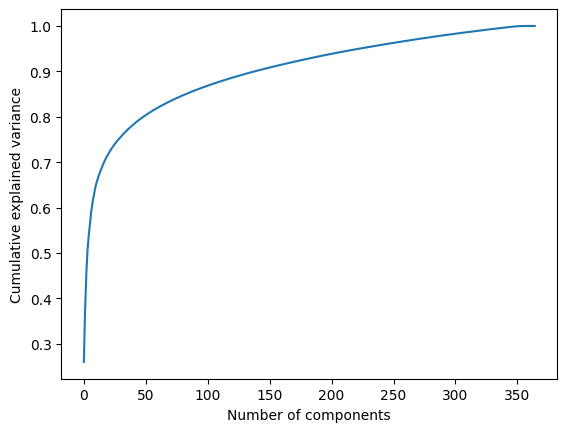

In [ ]:
# figuring out number of components for PCA
pca = PCA().fit(distance_matrix)  # fit without reducing dims first
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [275]:
pca_dimensions = 50  
pca = PCA(n_components=pca_dimensions)
distance_matrix_reduced = pca.fit_transform(distance_matrix)

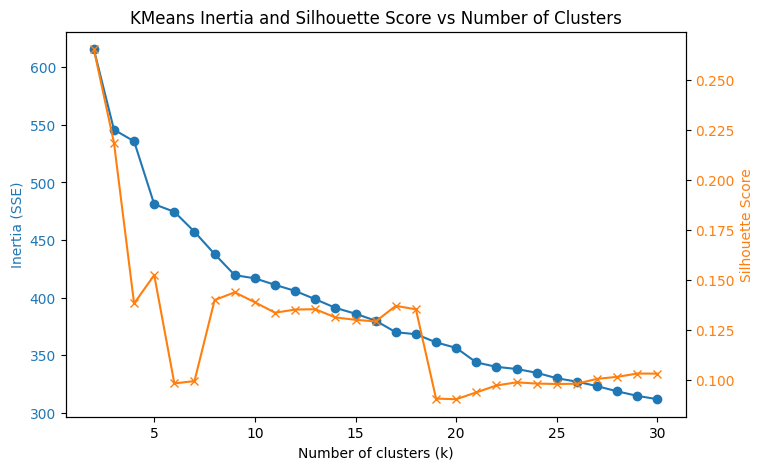

In [311]:
k_values = range(2, 31)
inertia_values = []
silhouette_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(distance_matrix)
    inertia_values.append(kmeans.inertia_)
    silhouette_values.append(metrics.silhouette_score(distance_matrix, labels))

# Plot
fig, ax1 = plt.subplots(figsize=(8,5))

color = 'tab:blue'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Inertia (SSE)', color=color)
ax1.plot(k_values, inertia_values, marker='o', color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # second y-axis
color = 'tab:orange'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_values, silhouette_values, marker='x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('KMeans Inertia and Silhouette Score vs Number of Clusters')
plt.show()

In [312]:
n_clusters = 17
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'teal', 'navy', 'maroon', 'lime', 'coral', 'gold', 'indigo']
kmeans = KMeans(n_clusters=n_clusters)
kmeans_labels = kmeans.fit(distance_matrix).labels_

In [ ]:
# tsne
tsne = TSNE(n_components=2)
tsne_coords = tsne.fit_transform(distance_matrix_reduced)
tsne_labels = kmeans.fit(tsne_coords).labels_

# umap
reducer = umap.UMAP(n_components=2)
umap_coords = reducer.fit_transform(distance_matrix_reduced)
umap_labels = kmeans.fit(umap_coords).labels_

# DataFrames
tsne_df = pd.DataFrame(tsne_coords, columns=['x', 'y'])
tsne_df['name'] = artists_df['name']
tsne_df['cluster'] = tsne_labels

umap_df = pd.DataFrame(umap_coords, columns=['x', 'y'])
umap_df['name'] = artists_df['name']
umap_df['cluster'] = umap_labels

# Create subplot figure
fig = make_subplots(rows=1, cols=2, subplot_titles=["t-SNE", "UMAP"])

# Add t-SNE scatter
fig.add_trace(
    go.Scatter(
        x=tsne_df["x"], y=tsne_df["y"],
        mode="markers",
        marker=dict(color=tsne_df["cluster"], colorscale="Viridis", size=6),
        text=tsne_df["name"],  # hover text
        hoverinfo="text"
    ),
    row=1, col=1
)

# Add UMAP scatter
fig.add_trace(
    go.Scatter(
        x=umap_df["x"], y=umap_df["y"],
        mode="markers",
        marker=dict(color=umap_df["cluster"], colorscale="Viridis", size=6),
        text=umap_df["name"],
        hoverinfo="text"
    ),
    row=1, col=2
)

fig.update_layout(height=500, width=1000, showlegend=False)
fig.show()
